In [1]:
import os
import numpy as np
import pandas as pd

import cv2
from scipy.cluster.vq import vq
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import seaborn as sns

In [2]:
class Dataset(object):

    def __init__(self, dataset_path):
        self.dataset_path = dataset_path

    def extract_dataset(self):
        images = []
        labels = []
        for subdir, dirs, files in os.walk(self.dataset_path):
            for filename in files:
                filepath = os.path.join(subdir, filename)
                if filepath.endswith(".jpg"):
                    label_parts = subdir.split(os.sep)
                    label = label_parts[-1] if label_parts[-1] != '' else label_parts[-2]  # Handling cases where the label might be the last part or second last part
                    images.append(filepath)
                    labels.append(label)

        return images, labels

In [3]:
obj = Dataset(dataset_path='15-Scene')
images, labels = obj.extract_dataset()

In [4]:
print(np.unique(labels))


['bedroom' 'coast' 'field' 'forest' 'highway' 'house' 'industrial'
 'kitchen' 'livingroom' 'mountain' 'office' 'store' 'street'
 'tallbuilding']


In [15]:
class BagOfVisualWords(object):

    def __init__(self, image_list):
        self.image_list = image_list

    def extract_sift_features(self):

        sift = cv2.SIFT_create()
        images_descriptors = dict()
        for image_path in self.image_list:
            image = cv2.imread(image_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            keypoints, descriptor = sift.detectAndCompute(gray, None)
            images_descriptors[image_path] = descriptor

        return images_descriptors
    def cluster_with_kmeans(self, descriptors, k_values):
        distortions = []
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=0)
            kmeans.fit(descriptors)
            distortions.append(kmeans.inertia_)
        return distortions

    def plot_clustering_results(self, k_values, distortions):
        plt.plot(k_values, distortions, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('Elbow Method For Optimal k for Scene Classification dataset')
        plt.show()

    def build_vocabulary(self, descriptors, vocab_size):

        k_means = KMeans(n_clusters=vocab_size, random_state=0).fit(descriptors)
        centers = k_means.cluster_centers_.tolist()
        closest, _ = pairwise_distances_argmin_min(centers, descriptors)
        vocabulary = descriptors[closest]

        return vocabulary

    def create_histograms(self, images_descriptors, vocabulary, vocab_size):

        histograms = np.zeros((len(self.image_list), vocab_size), dtype="float64")
        visuals_words_and_distances = [vq(images_descriptors[img], vocabulary) for img in self.image_list]
        for i, word_distance in enumerate(visuals_words_and_distances):
          for j in word_distance[0]:
              histograms[i][j] += 1

        return histograms

    def convert_to_ndarray(self, descriptors):

        descriptors_array = descriptors[0]
        for descriptor in descriptors[1:]:
          descriptors_array = np.concatenate((descriptors_array, descriptor), axis=0)

        return descriptors_array

    def convert_features_to_df(self, features):

        df = pd.DataFrame(features)
        img_idx = pd.Series([i for i in range(len(self.image_list))])
        df.set_index(img_idx)

        return df

    def normalize(self, features):

        scaler = MinMaxScaler().fit(features)
        normalized_features = scaler.transform(features)

        return normalized_features

In [16]:
bovw = BagOfVisualWords(images)

In [6]:
bovw = BagOfVisualWords(images)
images_descriptors = bovw.extract_sift_features()
descriptors_values = list(images_descriptors.values())
descriptors = bovw.convert_to_ndarray(descriptors_values)

In [7]:

# Define the range of k values
k_values = [1, 100, 200, 400, 500]


In [8]:
# Cluster with different k values
distortions = bovw.cluster_with_kmeans(descriptors, k_values)


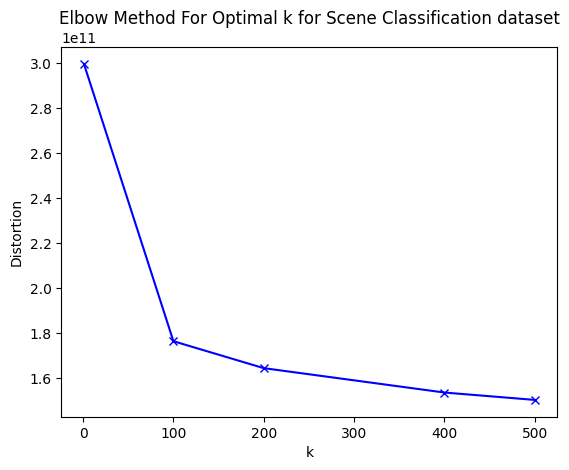

In [17]:
# Plot the clustering results
bovw.plot_clustering_results(k_values, distortions)

In [6]:
bovw = BagOfVisualWords(images)

In [8]:
images_descriptors = bovw.extract_sift_features()

In [9]:
descriptors_values = list(images_descriptors.values())

In [10]:
descriptors = bovw.convert_to_ndarray(descriptors_values)

In [11]:
vocabulary = bovw.build_vocabulary(descriptors=descriptors, vocab_size=100)

In [12]:
histograms = bovw.create_histograms(images_descriptors, vocabulary, 200)

In [13]:
histograms = bovw.normalize(histograms)

In [14]:
histogram_df = bovw.convert_features_to_df(histograms)

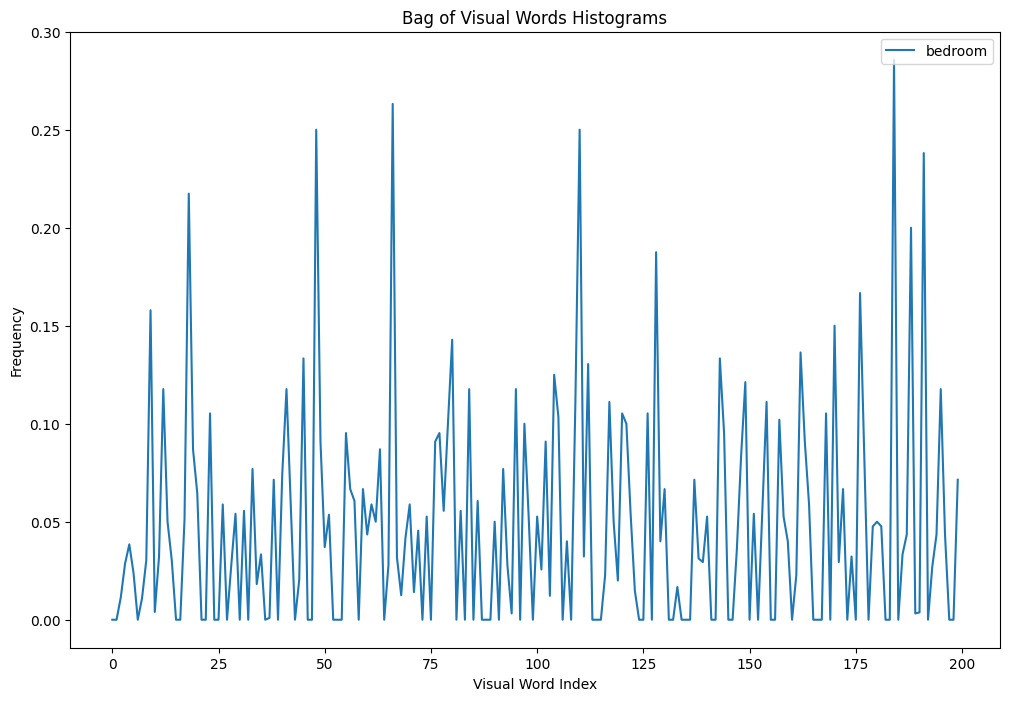

In [58]:
# Plotting the histograms
plt.figure(figsize=(12, 8))

plt.plot(histograms[0], label=labels[0])
plt.title('Bag of Visual Words Histograms')
plt.xlabel('Visual Word Index')
plt.ylabel('Frequency')
plt.legend(labels, loc='upper right')  # Display all labels
plt.show()


In [39]:
x_train_df, x_test_df, y_train, y_test = train_test_split(histogram_df, labels, random_state=42, shuffle=True,
                                                              test_size=0.20)
x_train = np.asarray(x_train_df)
x_test = np.asarray(x_test_df)

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

In [328]:
class LinearClassifier(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.classes = ['bedroom', 'coast', 'field', 'forest', 'highway', 'house', 'industrial',
                        'kitchen', 'livingroom', 'mountain', 'office', 'store', 'street',
                        'tallbuilding']

    def svm_classifier(self):
        svc_model = SVC()
        svc = svc_model.fit(self.x_train, self.y_train)
        svc_predicted = svc.predict(self.x_test)
        print('SVM Accuracy: ', str(self.calculate_accuracy(svc_predicted)))
        print('***SVM Classification Results***\n', classification_report(self.y_test, svc_predicted))
        self.create_confusion_matrix(svc_predicted, 'SVM')
        return svc_predicted

    def knn_classifier(self):
        knn_model = KNeighborsClassifier().fit(self.x_train, self.y_train)
        knn_predicted = knn_model.predict(self.x_test)
        print('KNN Accuracy: ', str(self.calculate_accuracy(knn_predicted)))
        print('***KNN Classification Results***\n', classification_report(self.y_test, knn_predicted))
        #  self.create_confusion_matrix(self,knn_predicted, 'KNN')
        return knn_predicted

    def calculate_accuracy(self, y_pred):
        # accuracy TP+TN / TP+TN+FP+FN == correct/all
        correct = 0
        for pred, real in zip(y_pred,self.y_test):
            if pred == real:
                correct += 1
        acc = correct / float(len(y_pred)) * 100.0

        return acc

    def create_confusion_matrix(self, y_pred, exp):

        cm = confusion_matrix(self.y_test, y_pred, labels=self.classes)
        disp=ConfusionMatrixDisplay(cm, display_labels=['bedroom', 'coast', 'field', 'forest', 'highway', 'house', 'industrial',
               'kitchen', 'livingroom', 'mountain', 'office', 'store', 'street',
               'tallbuilding'])
        disp.plot()
        disp.ax_.set_title('Confusion Matrix (SIFT+BoW+SVM)')
        plt.xticks(rotation=90, ha='right')
        plt.show()
        print(cm)
        return

SVM Accuracy:  60.4066985645933
***SVM Classification Results***
               precision    recall  f1-score   support

     bedroom       0.56      0.25      0.34        57
       coast       0.65      0.70      0.67        80
       field       0.62      0.57      0.59        81
      forest       0.83      0.93      0.88        81
     highway       0.57      0.65      0.61        51
       house       0.88      0.85      0.86        52
  industrial       0.30      0.36      0.32        50
     kitchen       0.45      0.36      0.40        42
  livingroom       0.41      0.45      0.43        65
    mountain       0.62      0.68      0.65        62
      office       0.61      0.56      0.58        45
       store       0.57      0.70      0.63        54
      street       0.57      0.50      0.53        58
tallbuilding       0.67      0.71      0.69        58

    accuracy                           0.60       836
   macro avg       0.59      0.59      0.58       836
weighted avg  

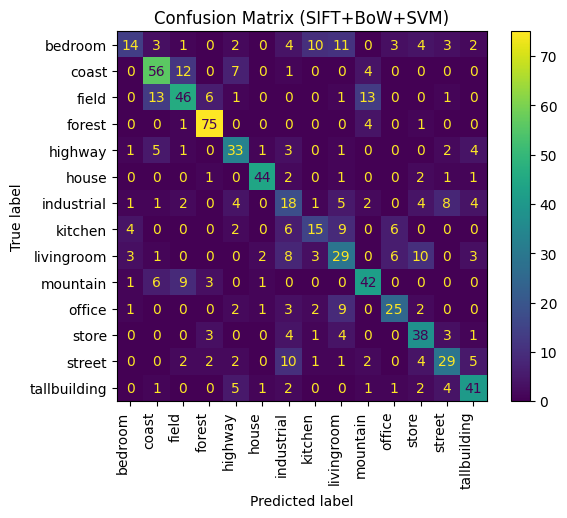

[[14  3  1  0  2  0  4 10 11  0  3  4  3  2]
 [ 0 56 12  0  7  0  1  0  0  4  0  0  0  0]
 [ 0 13 46  6  1  0  0  0  1 13  0  0  1  0]
 [ 0  0  1 75  0  0  0  0  0  4  0  1  0  0]
 [ 1  5  1  0 33  1  3  0  1  0  0  0  2  4]
 [ 0  0  0  1  0 44  2  0  1  0  0  2  1  1]
 [ 1  1  2  0  4  0 18  1  5  2  0  4  8  4]
 [ 4  0  0  0  2  0  6 15  9  0  6  0  0  0]
 [ 3  1  0  0  0  2  8  3 29  0  6 10  0  3]
 [ 1  6  9  3  0  1  0  0  0 42  0  0  0  0]
 [ 1  0  0  0  2  1  3  2  9  0 25  2  0  0]
 [ 0  0  0  3  0  0  4  1  4  0  0 38  3  1]
 [ 0  0  2  2  2  0 10  1  1  2  0  4 29  5]
 [ 0  1  0  0  5  1  2  0  0  1  1  2  4 41]]


In [329]:
clf = LinearClassifier(x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)
svm_predicted_sift = clf.svm_classifier()

In [280]:
from skimage.feature import hog

class Dataset:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path

    def extract_dataset(self):
        images = []
        labels = []
        for subdir, dirs, files in os.walk(self.dataset_path):
            for filename in files:
                filepath = os.path.join(subdir, filename)
                if filepath.endswith(".jpg"):
                    label_parts = subdir.split(os.sep)
                    label = label_parts[-1] if label_parts[-1] != '' else label_parts[-2]  
                    images.append(filepath)
                    labels.append(label)

        return images, labels

class HOGSVM:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def extract_hog_features(self, image_paths):
        hog_features = []
        for image_path in image_paths:
            image = cv2.imread(image_path)
            if image is not None:
                # Resize image to a fixed size
                image = cv2.resize(image, (64, 128))
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                hog_feature = hog(gray, orientations=3, pixels_per_cell=(32, 32),
                    	cells_per_block=(2, 2))
                hog_features.append(hog_feature)
            else:
                print(f"Invalid file path: {image_path}")
        return np.array(hog_features)

    def train_svm(self, features, labels):
        svm_model = SVC()
        svm_model.fit(features, labels)
        return svm_model

    def evaluate_svm(self, svm_model, test_features, test_labels):
        predictions = svm_model.predict(test_features)
        print('***SVM Classification Results***\n', classification_report(test_labels, predictions))

In [281]:
# Usage
dataset_obj = Dataset(dataset_path='15-Scene')
images, labels = dataset_obj.extract_dataset()

# Split data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [282]:
# HOG feature extraction
hog_svm = HOGSVM(train_images, train_labels)


In [283]:
train_features = hog_svm.extract_hog_features(train_images)


In [284]:
test_features = hog_svm.extract_hog_features(test_images)

In [285]:
# Train SVM
svm_model = hog_svm.train_svm(train_features, train_labels)

In [286]:
print(train_features.shape)
print(len(test_labels))

(3341, 36)
836


In [287]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict labels using the trained SVM model
predictions = svm_model.predict(test_features)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy*100, "%")

Accuracy: 49.760765550239235 %


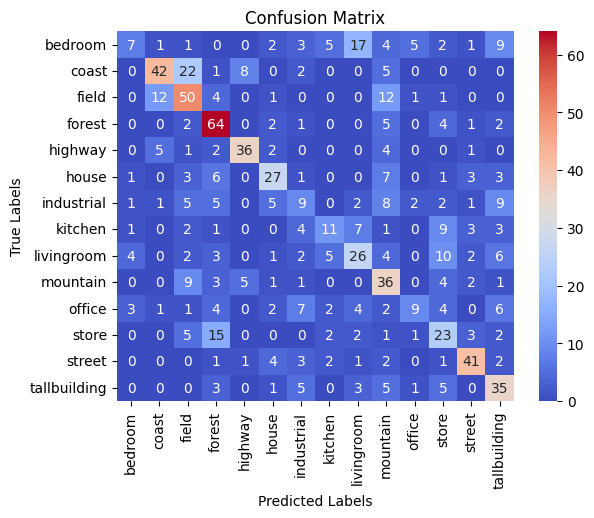

In [288]:
# Plot confusion matrix with labels using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cmat = confusion_matrix(test_labels, predictions)

# Define label names
label_names = ['bedroom', 'coast', 'field', 'forest', 'highway', 'house', 'industrial',
               'kitchen', 'livingroom', 'mountain', 'office', 'store', 'street',
               'tallbuilding']

# Plot confusion matrix using Seaborn
sns.heatmap(cmat, annot=True, cmap='coolwarm', fmt="d", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [317]:
# Evaluate SVM
hog_svm.evaluate_svm(svm_model, test_features, test_labels)

***SVM Classification Results***
               precision    recall  f1-score   support

     bedroom       0.41      0.12      0.19        57
       coast       0.68      0.53      0.59        80
       field       0.49      0.62      0.54        81
      forest       0.57      0.79      0.66        81
     highway       0.72      0.71      0.71        51
       house       0.56      0.52      0.54        52
  industrial       0.24      0.18      0.20        50
     kitchen       0.41      0.26      0.32        42
  livingroom       0.42      0.40      0.41        65
    mountain       0.38      0.58      0.46        62
      office       0.47      0.20      0.28        45
       store       0.35      0.43      0.38        54
      street       0.71      0.71      0.71        58
tallbuilding       0.45      0.60      0.51        58

    accuracy                           0.50       836
   macro avg       0.49      0.47      0.47       836
weighted avg       0.50      0.50      0.48   

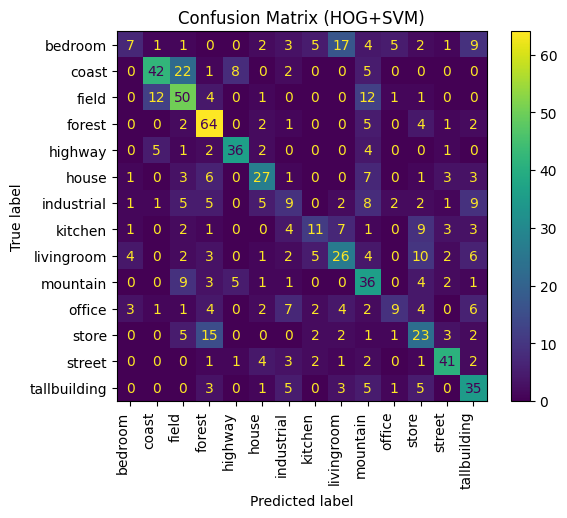

In [321]:
from sklearn.metrics import ConfusionMatrixDisplay
disp=ConfusionMatrixDisplay(cmat, display_labels=['bedroom', 'coast', 'field', 'forest', 'highway', 'house', 'industrial',
               'kitchen', 'livingroom', 'mountain', 'office', 'store', 'street',
               'tallbuilding'])
disp.plot()
disp.ax_.set_title('Confusion Matrix (HOG+SVM)')
plt.xticks(rotation=90, ha='right')
plt.show()

In [330]:
print(cmat)

[[ 7  1  1  0  0  2  3  5 17  4  5  2  1  9]
 [ 0 42 22  1  8  0  2  0  0  5  0  0  0  0]
 [ 0 12 50  4  0  1  0  0  0 12  1  1  0  0]
 [ 0  0  2 64  0  2  1  0  0  5  0  4  1  2]
 [ 0  5  1  2 36  2  0  0  0  4  0  0  1  0]
 [ 1  0  3  6  0 27  1  0  0  7  0  1  3  3]
 [ 1  1  5  5  0  5  9  0  2  8  2  2  1  9]
 [ 1  0  2  1  0  0  4 11  7  1  0  9  3  3]
 [ 4  0  2  3  0  1  2  5 26  4  0 10  2  6]
 [ 0  0  9  3  5  1  1  0  0 36  0  4  2  1]
 [ 3  1  1  4  0  2  7  2  4  2  9  4  0  6]
 [ 0  0  5 15  0  0  0  2  2  1  1 23  3  2]
 [ 0  0  0  1  1  4  3  2  1  2  0  1 41  2]
 [ 0  0  0  3  0  1  5  0  3  5  1  5  0 35]]
